In [ ]:
# Install transformers library.
!pip install -q git+https://github.com/huggingface/transformers.git
# Install helper functions./
!pip install -q git+https://github.com/gmihaila/ml_things.git
!pip install matplotlib==3.1.3

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 596 kB 25.1 MB/s 
     |████████████████████████████████| 101 kB 12.2 MB/s 
     |████████████████████████████████| 6.6 MB 46.8 MB/s 
     |████████████████████████████████| 53 kB 1.7 MB/s 
     |████████████████████████████████| 11.2 MB 55.2 MB/s 
     |████████████████████████████████| 944 kB 56.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 36.5 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.2
    Uninstalling matplotlib-3.5.2:
      Successfully uninstalled matplotlib-3.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ml-things 0.0.1 requires m

In [ ]:
from matplotlib import _png
import pandas as pd
import numpy as np
import json
#import openai
import time
from sklearn import metrics
from sklearn.model_selection import train_test_split
import re
import nltk
import io
import os
import torch
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          AdamW, 
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification)
set_seed(123)
epochs = 1
batch_size = 32
max_length = 60
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_or_path = 'gpt2'

In [ ]:
def oversample(df):
    classes = df.label.value_counts().to_dict()
    most = max(classes.values())
    classes_list = []
    for key in classes:
        classes_list.append(df[df['label'] == key]) 
    classes_sample = []
    for i in range(1,len(classes_list)):
        classes_sample.append(classes_list[i].sample(most, replace=True))
    df_maybe = pd.concat(classes_sample)
    final_df = pd.concat([df_maybe,classes_list[0]], axis=0)
    final_df = final_df.reset_index(drop=True)
    return final_df

In [ ]:
class Dataset(Dataset):
  def __init__(self, data, use_tokenizer):
    self.texts =  [text for text in data['text']]
    self.labels = [label for label in data['label']]
    self.n_examples = len(self.labels)
    return
  def __len__(self):   
    return self.n_examples
  def __getitem__(self, item):
    return {'text':self.texts[item],
            'label':self.labels[item]}
class Gpt2ClassificationCollator(object):
    def __init__(self, use_tokenizer, labels_encoder, max_sequence_len=None):
        self.use_tokenizer = use_tokenizer
        self.max_sequence_len = use_tokenizer.model_max_length if max_sequence_len is None else max_sequence_len
        self.labels_encoder = labels_encoder
        return
    def __call__(self, sequences):
        texts = [sequence['text'] for sequence in sequences]
        labels = [sequence['label'] for sequence in sequences]
        labels = [self.labels_encoder[label] for label in labels]
        inputs = self.use_tokenizer(text=texts, return_tensors="pt", padding=True, truncation=True,  max_length=self.max_sequence_len)
        inputs.update({'labels':torch.tensor(labels)})
        return inputs
def softmax(_outputs):
    maxes = np.max(_outputs, axis=-1, keepdims=True)
    shifted_exp = np.exp(_outputs - maxes)
    return shifted_exp / shifted_exp.sum(axis=-1, keepdims=True)
def train(dataloader, optimizer_, scheduler_, device_):
  global model
  predictions_labels = []
  true_labels = []
  total_loss = 0
  score = []
  model.train()
  for batch in tqdm(dataloader, total=len(dataloader)):
    true_labels += batch['labels'].numpy().flatten().tolist()
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}
    model.zero_grad()
    outputs = model(**batch)
    loss, logits = outputs[:2]
    total_loss += loss.item()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer_.step()
    scheduler_.step()
    logits = logits.detach().cpu().numpy()
    predictions_labels += logits.argmax(axis=-1).flatten().tolist()
    score += softmax(logits).tolist()
  avg_epoch_loss = total_loss / len(dataloader)   
  
  return true_labels, predictions_labels, avg_epoch_loss, score

def validation(dataloader, device_):
  global model
  predictions_labels = []
  true_labels = []
  total_loss = 0
  score = []
  model.eval()
  for batch in tqdm(dataloader, total=len(dataloader)):
    true_labels += batch['labels'].numpy().flatten().tolist()
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}
    with torch.no_grad():        
        outputs = model(**batch)
        loss, logits = outputs[:2]
        logits = logits.detach().cpu().numpy()
        total_loss += loss.item()
        predict_content = logits.argmax(axis=-1).flatten().tolist()
        predictions_labels += predict_content
        score += softmax(logits).tolist()
  avg_epoch_loss = total_loss / len(dataloader)
  
  return true_labels, predictions_labels, avg_epoch_loss, score

#SBIC#

In [ ]:
#SBIC Disagreement
SBIC_Disagreement = pd.read_csv('/content/drive/MyDrive/Morality   Legality/Disagreement_Datasets/SBIC_Disagreement.csv')

In [79]:
#input: text + personal demographic 
#output: personal disagreement
SBIC_Person_Disagreement = SBIC_Disagreement[['person_disagreement']]
SBIC_Person_Disagreement['demographics_text'] = ["The annotator is a " + str(int(SBIC_Disagreement['annotatorAge'].iloc[i])) + ' years old ' + str(SBIC_Disagreement['annotatorPolitics'].iloc[i]) + ' ' + str(SBIC_Disagreement['annotatorRace'].iloc[i]) + ' ' + str(SBIC_Disagreement['annotatorGender'].iloc[i]) + ". " + str(SBIC_Disagreement['text'].iloc[i]) for i in range(len(SBIC_Disagreement))]
SBIC_Person_Disagreement = SBIC_Person_Disagreement.rename(columns={'demographics_text':'text','person_disagreement': 'label'})
SBIC_Person_Disagreement['label']= SBIC_Person_Disagreement['label'].astype(str) 
labels_ids = {'0':0,  '1':1}
n_labels = 2
train_SBIC_Person_Disagreement, validate_SBIC_Person_Disagreement, test_SBIC_Person_Disagreement = np.split(SBIC_Person_Disagreement.sample(frac=1, random_state=42),[int(.6*len(SBIC_Person_Disagreement)), int(.8*len(SBIC_Person_Disagreement))])
train_SBIC_Person_Disagreement_oversampled = oversample(train_SBIC_Person_Disagreement)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token
print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)
model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = model.config.eos_token_id
model.to(device)
print('Model loaded to `%s`'%device)

gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer, 
                                                          labels_encoder=labels_ids, 
                                                          max_sequence_len=max_length)
#update datasets
train_dataset = Dataset(data = train_SBIC_Person_Disagreement_oversampled, use_tokenizer=tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
valid_dataset =  Dataset(data = validate_SBIC_Person_Disagreement, use_tokenizer=tokenizer)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
test_dataset =  Dataset(data = test_SBIC_Person_Disagreement, use_tokenizer=tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)

optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # default is 1e-8.
                  )
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}
print('Epoch')
for epoch in tqdm(range(epochs)):
  print()
  print('Training on batches...')
  train_labels, train_predict, train_loss, train_logits = train(train_dataloader, optimizer, scheduler, device)
  print('Validation on batches...')
  valid_labels, valid_predict, val_loss, val_logits = validation(valid_dataloader, device)
  print("  train_loss: %.5f - val_loss: %.5f: "%(train_loss, val_loss,))
  print()
  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)
  
true_labels, predictions_labels, avg_epoch_loss, logits = validation(test_dataloader, device)
print(avg_epoch_loss)

In [82]:
test_dataset =  Dataset(data = test_SBIC_Person_Disagreement, use_tokenizer=tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)

true_labels, predictions_labels, avg_epoch_loss, logits = validation(test_dataloader, device)
print(avg_epoch_loss)

  0%|          | 0/562 [00:00<?, ?it/s]

0.6742558410371325


In [ ]:
# input: text
# output: group disagreement rate 
SBIC_Group_Disagreement_reg = SBIC_Disagreement[['text', 'normalized_disagreement_rate']].dropna()
SBIC_Group_Disagreement_reg = SBIC_Group_Disagreement_reg.rename(columns={ 'normalized_disagreement_rate': 'label'}).drop_duplicates()
SBIC_Group_Disagreement_reg['label']= SBIC_Group_Disagreement_reg['label'].astype(str) 
train_reg, validate_reg, test_reg = np.split(SBIC_Group_Disagreement_reg.sample(frac=1, random_state=42),[int(.6*len(SBIC_Group_Disagreement_reg)), int(.8*len(SBIC_Group_Disagreement_reg))])
train_reg['label'].value_counts()
train_reg_oversampled = oversample(train_reg)
labels_ids = {'0.0':0, '0.5': 0.5, '1.0':1}
n_labels = 3

In [ ]:
train_reg_oversampled

,text,label
0,that grandpa is so fucking annoying who the fu...,0.5
1,don't post no men on my page . don't got time ...,0.5
2,wonder if food stamps would cover s t for th...,0.5
3,if i was al franken's defense attorney i would...,0.5
4,so my cat went to the vet and they shaved her ...,0.5
...,...,...
33511,i never check msg requests on ig. one i just o...,0.0
33512,what's the difference between a main amp a sid...,0.0
33513,i'm in a canadian city of about 30000 .,0.0
33514,how can they do well at anything that requires...,0.0


In [ ]:
print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token
print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)
model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = model.config.eos_token_id
model.to(device)
print('Model loaded to `%s`'%device)

Loading configuraiton...
Loading tokenizer...
Loading model...


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cuda`


In [ ]:
gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer, 
                                                          labels_encoder=labels_ids, 
                                                          max_sequence_len=max_length)

print('Dealing with Train...')
train_dataset = Dataset(data = train_reg_oversampled, 
                               use_tokenizer=tokenizer)
print('Created `train_dataset` with %d examples!'%len(train_dataset))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))
print()
print('Dealing with Validation...')
valid_dataset =  Dataset(data = validate_reg, 
                               use_tokenizer=tokenizer)

print('Created `valid_dataset` with %d examples!'%len(valid_dataset))
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Created `eval_dataloader` with %d batches!'%len(valid_dataloader))

Dealing with Train...
Created `train_dataset` with 33516 examples!
Created `train_dataloader` with 1048 batches!

Dealing with Validation...
Created `valid_dataset` with 5994 examples!
Created `eval_dataloader` with 188 batches!


Epoch


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/4 [00:00<?, ?it/s]


Training on batches...


  0%|          | 0/1048 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/188 [00:00<?, ?it/s]

  train_loss: 0.27272 - val_loss: 0.56120: 


Training on batches...


  0%|          | 0/1048 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/188 [00:00<?, ?it/s]

  train_loss: 0.20913 - val_loss: 0.58251: 


Training on batches...


  0%|          | 0/1048 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/188 [00:00<?, ?it/s]

  train_loss: 0.26431 - val_loss: 0.43384: 


Training on batches...


  0%|          | 0/1048 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/188 [00:00<?, ?it/s]

  train_loss: 0.26740 - val_loss: 0.44739: 



/usr/local/lib/python3.7/dist-packages/ml_things/plot_functions.py:410: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  DeprecationWarning)


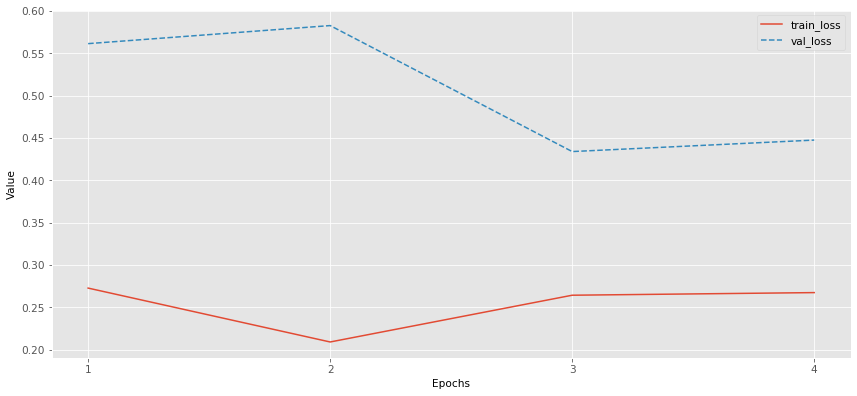

/usr/local/lib/python3.7/dist-packages/ml_things/plot_functions.py:410: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  DeprecationWarning)


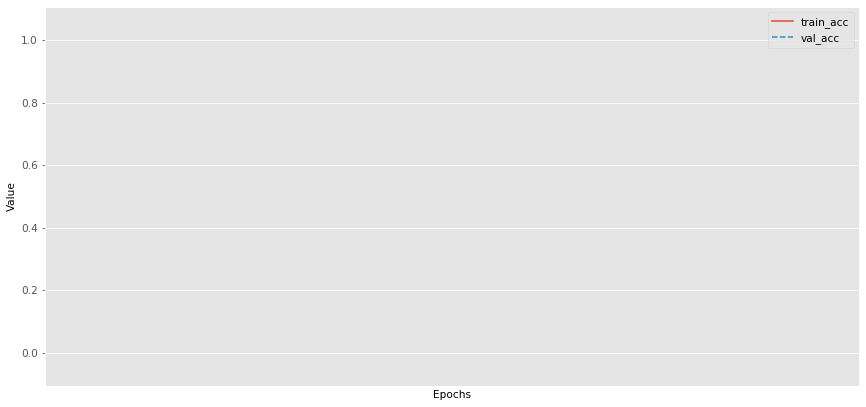

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # default is 1e-8.
                  )
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}
print('Epoch')
for epoch in tqdm(range(epochs)):
  print()
  print('Training on batches...')
  train_labels, train_predict, train_loss, train_logits = train(train_dataloader, optimizer, scheduler, device)
  print('Validation on batches...')
  valid_labels, valid_predict, val_loss, val_logits = validation(valid_dataloader, device)
  print("  train_loss: %.5f - val_loss: %.5f: "%(train_loss, val_loss,))
  print()
  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)
  
plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

In [ ]:
test_dataset =  Dataset(data = test_reg, 
                               use_tokenizer=tokenizer)

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
true_labels, predictions_labels, avg_epoch_loss, logits = validation(test_dataloader, device)
print(avg_epoch_loss)

  0%|          | 0/188 [00:00<?, ?it/s]

0.4645133969631601


In [ ]:
#input: group_demographic + text 
#output: group disagreement rate
SBIC_Disagreement['demographics'] = [" a " + str(int(SBIC_Disagreement['annotatorAge'].iloc[i])) + ' years old ' + str(SBIC_Disagreement['annotatorPolitics'].iloc[i]) + ' ' + str(SBIC_Disagreement['annotatorRace'].iloc[i]) + ' ' + str(SBIC_Disagreement['annotatorGender'].iloc[i])  for i in range(len(SBIC_Disagreement))]
SBIC_Disagreement['group_demographic'] = SBIC_Disagreement.groupby(['text'])['demographics'].transform(lambda x:'The annotators are' + ', and'.join(x) + '. ')
SBIC_Disagreement['group_demographic_text'] = SBIC_Disagreement['group_demographic'] + SBIC_Disagreement['text']

SBIC_Group_demographic_text_Disagreement_reg = SBIC_Disagreement[['group_demographic_text', 'normalized_disagreement_rate']].dropna()
SBIC_Group_demographic_text_Disagreement_reg = SBIC_Group_demographic_text_Disagreement_reg.rename(columns={'group_demographic_text':'text' ,'normalized_disagreement_rate': 'label'}).drop_duplicates()
SBIC_Group_demographic_text_Disagreement_reg['label']= SBIC_Group_demographic_text_Disagreement_reg['label'].astype(str) 

train_Group_demographic_text_reg, validate_Group_demographic_text_reg, test_Group_demographic_text_reg = np.split(SBIC_Group_demographic_text_Disagreement_reg.sample(frac=1, random_state=42),[int(.6*len(SBIC_Group_demographic_text_Disagreement_reg)), int(.8*len(SBIC_Group_demographic_text_Disagreement_reg))])
print(test_Group_demographic_text_reg['label'].value_counts())
train_Group_demographic_text_reg_oversampled = oversample(train_Group_demographic_text_reg)

0.0    3722
0.5    1932
1.0     341
Name: label, dtype: int64


In [ ]:
labels_ids = {'0.0':0, '0.5': 0.5, '1.0':1}
n_labels = 3

Loading configuraiton...
Loading tokenizer...
Loading model...


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cuda`
Epoch


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/4 [00:00<?, ?it/s]


Training on batches...


  0%|          | 0/1048 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/188 [00:00<?, ?it/s]

  train_loss: 0.57938 - val_loss: 0.35256: 


Training on batches...


  0%|          | 0/1048 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/188 [00:00<?, ?it/s]

  train_loss: 0.35693 - val_loss: 0.37397: 


Training on batches...


  0%|          | 0/1048 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/188 [00:00<?, ?it/s]

  train_loss: 0.21472 - val_loss: 0.46034: 


Training on batches...


  0%|          | 0/1048 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/188 [00:00<?, ?it/s]

  train_loss: 0.16601 - val_loss: 0.45463: 



/usr/local/lib/python3.7/dist-packages/ml_things/plot_functions.py:410: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  DeprecationWarning)


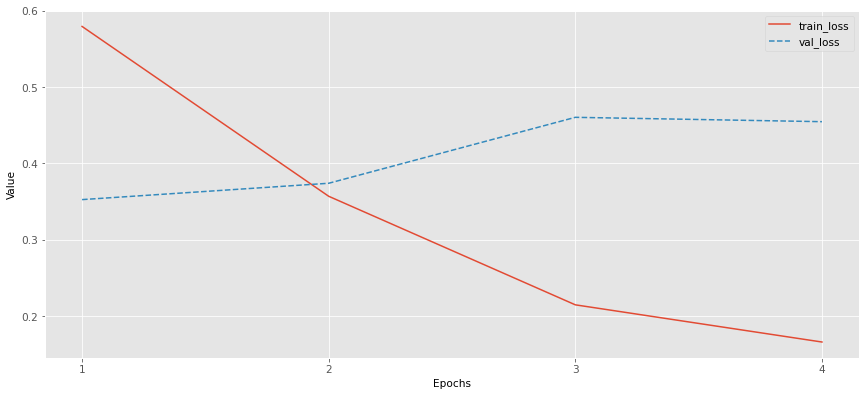

NameError: ignored

In [ ]:
print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token
print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)
model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = model.config.eos_token_id
model.to(device)
print('Model loaded to `%s`'%device)

gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer, 
                                                          labels_encoder=labels_ids, 
                                                          max_sequence_len=max_length)
#update datasets
train_dataset = Dataset(data = train_Group_demographic_text_reg_oversampled, 
                               use_tokenizer=tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
valid_dataset =  Dataset(data = validate_Group_demographic_text_reg, 
                               use_tokenizer=tokenizer)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
test_dataset =  Dataset(data = test_Group_demographic_text_reg, 
                               use_tokenizer=tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)

optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # default is 1e-8.
                  )
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}
print('Epoch')
for epoch in tqdm(range(epochs)):
  print()
  print('Training on batches...')
  train_labels, train_predict, train_loss, train_logits = train(train_dataloader, optimizer, scheduler, device)
  print('Validation on batches...')
  valid_labels, valid_predict, val_loss, val_logits = validation(valid_dataloader, device)
  print("  train_loss: %.5f - val_loss: %.5f: "%(train_loss, val_loss,))
  print()
  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)
  
plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

In [ ]:
test_dataset =  Dataset(data = test_Group_demographic_text_reg, use_tokenizer=tokenizer)

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
true_labels, predictions_labels, avg_epoch_loss, logits = validation(test_dataloader, device)
print(avg_epoch_loss)

  0%|          | 0/188 [00:00<?, ?it/s]

0.502273031153736


In [ ]:
# input: one person's demographic + text in a sentence format
# ouput: group disagreement rate
SBIC_Disagreement['demographics_text'] = ["The annotator is a " + str(int(SBIC_Disagreement['annotatorAge'].iloc[i])) + ' years old ' + str(SBIC_Disagreement['annotatorPolitics'].iloc[i]) + ' ' + str(SBIC_Disagreement['annotatorRace'].iloc[i]) + ' ' + str(SBIC_Disagreement['annotatorGender'].iloc[i]) + ". " + str(SBIC_Disagreement['text'].iloc[i]) for i in range(len(SBIC_Disagreement))]
SBIC_demo_text_Group_Disagreement_reg = SBIC_Disagreement[['demographics_text', 'normalized_disagreement_rate']].dropna()
SBIC_demo_text_Group_Disagreement_reg = SBIC_demo_text_Group_Disagreement_reg.rename(columns={'demographics_text':'text','normalized_disagreement_rate': 'label'}).drop_duplicates()
SBIC_demo_text_Group_Disagreement_reg['label']= SBIC_demo_text_Group_Disagreement_reg['label'].astype(str) 

train_SBIC_demo_text_Group_reg, validate_SBIC_demo_text_Group_reg, test_SBIC_demo_text_Group_reg = np.split(SBIC_demo_text_Group_Disagreement_reg.sample(frac=1, random_state=42),[int(.6*len(SBIC_demo_text_Group_Disagreement_reg)), int(.8*len(SBIC_demo_text_Group_Disagreement_reg))])
train_SBIC_demo_text_Group_reg_oversampled = oversample(train_SBIC_demo_text_Group_reg)

In [ ]:
train_SBIC_demo_text_Group_reg_oversampled

,text,label
0,The annotator is a 31 years old other white wo...,0.5
1,The annotator is a 27 years old mod-liberal wh...,0.5
2,The annotator is a 34 years old liberal white ...,0.5
3,The annotator is a 55 years old mod-liberal wh...,0.5
4,The annotator is a 32 years old mod-liberal wh...,0.5
...,...,...
100204,The annotator is a 31 years old other white wo...,0.0
100205,The annotator is a 25 years old mod-liberal wh...,0.0
100206,The annotator is a 49 years old cons white man...,0.0
100207,The annotator is a 22 years old liberal white ...,0.0


Loading configuraiton...
Loading tokenizer...
Loading model...


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cuda`
Epoch


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/1 [00:00<?, ?it/s]


Training on batches...


  0%|          | 0/3132 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/560 [00:00<?, ?it/s]

  train_loss: 0.60797 - val_loss: 0.39644: 



/usr/local/lib/python3.7/dist-packages/ml_things/plot_functions.py:410: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  DeprecationWarning)


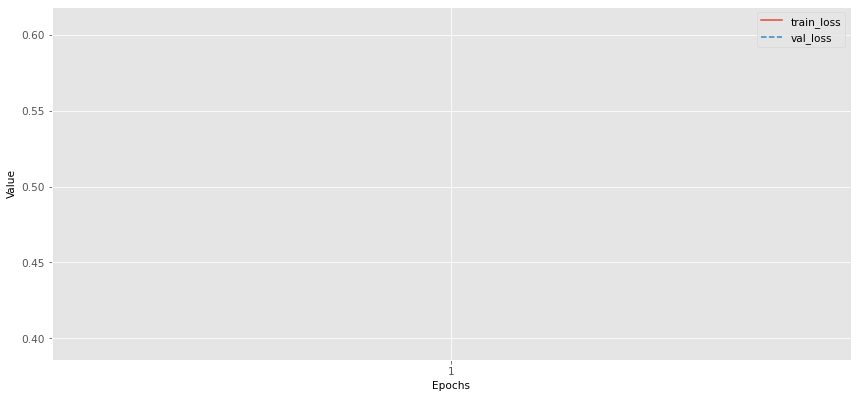

NameError: ignored

In [ ]:
print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token
print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)
model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = model.config.eos_token_id
model.to(device)
print('Model loaded to `%s`'%device)

gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer, 
                                                          labels_encoder=labels_ids, 
                                                          max_sequence_len=max_length)
#update datasets
train_dataset = Dataset(data = train_SBIC_demo_text_Group_reg_oversampled, use_tokenizer=tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
valid_dataset =  Dataset(data = validate_SBIC_demo_text_Group_reg, use_tokenizer=tokenizer)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
test_dataset =  Dataset(data = test_SBIC_demo_text_Group_reg, use_tokenizer=tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)

optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # default is 1e-8.
                  )
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}
print('Epoch')
for epoch in tqdm(range(epochs)):
  print()
  print('Training on batches...')
  train_labels, train_predict, train_loss, train_logits = train(train_dataloader, optimizer, scheduler, device)
  print('Validation on batches...')
  valid_labels, valid_predict, val_loss, val_logits = validation(valid_dataloader, device)
  print("  train_loss: %.5f - val_loss: %.5f: "%(train_loss, val_loss,))
  print()
  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)
  
plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])
test_dataset =  Dataset(data = test_SBIC_demo_text_Group_reg, use_tokenizer=tokenizer)

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
true_labels, predictions_labels, avg_epoch_loss, logits = validation(test_dataloader, device)
print(avg_epoch_loss)

In [ ]:
test_dataset =  Dataset(data = test_SBIC_demo_text_Group_reg, use_tokenizer=tokenizer)

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
true_labels, predictions_labels, avg_epoch_loss, logits = validation(test_dataloader, device)
print(avg_epoch_loss)

  0%|          | 0/560 [00:00<?, ?it/s]

0.39304853794830186


In [ ]:
#input: one person's demographic + text: 
#age: x1,...text: ..
#output: group disagreement rate
#change demographic template to age:25, race: white, text: ...
SBIC_Disagreement['demographics_text_newtemp'] = ["age: " + str(int(SBIC_Disagreement['annotatorAge'].iloc[i])) + ', politics: ' + str(SBIC_Disagreement['annotatorPolitics'].iloc[i]) + ', race: ' + str(SBIC_Disagreement['annotatorRace'].iloc[i]) + ', gender ' + str(SBIC_Disagreement['annotatorGender'].iloc[i]) + ". text: " + str(SBIC_Disagreement['text'].iloc[i]) for i in range(len(SBIC_Disagreement))]
SBIC_demo_text_newtemp_Group_Disagreement_reg = SBIC_Disagreement[['demographics_text_newtemp', 'normalized_disagreement_rate']].dropna()
SBIC_demo_text_newtemp_Group_Disagreement_reg = SBIC_demo_text_newtemp_Group_Disagreement_reg.rename(columns={'demographics_text_newtemp':'text','normalized_disagreement_rate': 'label'}).drop_duplicates()
SBIC_demo_text_newtemp_Group_Disagreement_reg['label']= SBIC_demo_text_newtemp_Group_Disagreement_reg['label'].astype(str) 

train_SBIC_demo_text_newtemp_Group_reg, validate_SBIC_demo_text_newtemp_Group_reg, test_SBIC_demo_text_newtemp_Group_reg = np.split(SBIC_demo_text_newtemp_Group_Disagreement_reg.sample(frac=1, random_state=42),[int(.6*len(SBIC_demo_text_newtemp_Group_Disagreement_reg)), int(.8*len(SBIC_demo_text_newtemp_Group_Disagreement_reg))])
train_SBIC_demo_text_newtemp_Group_reg_oversampled = oversample(train_SBIC_demo_text_newtemp_Group_reg)

In [ ]:
print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token
print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)
model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = model.config.eos_token_id
model.to(device)
print('Model loaded to `%s`'%device)

gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer, 
                                                          labels_encoder=labels_ids, 
                                                          max_sequence_len=max_length)
#update datasets
train_dataset = Dataset(data = train_SBIC_demo_text_newtemp_Group_reg_oversampled, 
                               use_tokenizer=tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
valid_dataset =  Dataset(data = validate_SBIC_demo_text_newtemp_Group_reg, 
                               use_tokenizer=tokenizer)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
test_dataset =  Dataset(data = test_SBIC_demo_text_Group_reg, 
                               use_tokenizer=tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)

optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # default is 1e-8.
                  )
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}
print('Epoch')
for epoch in tqdm(range(epochs)):
  print()
  print('Training on batches...')
  train_labels, train_predict, train_loss, train_logits = train(train_dataloader, optimizer, scheduler, device)
  print('Validation on batches...')
  valid_labels, valid_predict, val_loss, val_logits = validation(valid_dataloader, device)
  print("  train_loss: %.5f - val_loss: %.5f: "%(train_loss, val_loss,))
  print()
  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)
  
true_labels, predictions_labels, avg_epoch_loss, logits = validation(test_dataloader, device)
print(avg_epoch_loss)

Loading configuraiton...
Loading tokenizer...
Loading model...


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cuda`
Epoch


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/1 [00:00<?, ?it/s]


Training on batches...


  0%|          | 0/3132 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/560 [00:00<?, ?it/s]

  train_loss: 0.58537 - val_loss: 0.35005: 



  0%|          | 0/560 [00:00<?, ?it/s]

0.2909116952280913


#Dilemmas

In [ ]:
train_dilemmas_disagreement = pd.read_csv('/content/drive/MyDrive/Morality   Legality/Disagreement_Datasets/train_dilemmas_disagreement.csv')
dev_dilemmas_disagreement = pd.read_csv('/content/drive/MyDrive/Morality   Legality/Disagreement_Datasets/dev_dilemmas_disagreement.csv')
test_dilemmas_disagreement = pd.read_csv('/content/drive/MyDrive/Morality   Legality/Disagreement_Datasets/test_dilemmas_disagreement.csv')

In [ ]:
train_dilemmas_disagreement = train_dilemmas_disagreement[['text', 'normalized_disagreement_rate']]
dev_dilemmas_disagreement = dev_dilemmas_disagreement[['text', 'normalized_disagreement_rate']]
test_dilemmas_disagreement = test_dilemmas_disagreement[['text', 'normalized_disagreement_rate']]
train_dilemmas_disagreement= train_dilemmas_disagreement.rename(columns={'normalized_disagreement_rate': 'label'})
dev_dilemmas_disagreement = dev_dilemmas_disagreement.rename(columns={'normalized_disagreement_rate': 'label'})
test_dilemmas_disagreement = test_dilemmas_disagreement.rename(columns={'normalized_disagreement_rate': 'label'})
train_dilemmas_disagreement['label']= train_dilemmas_disagreement['label'].astype(str) 
dev_dilemmas_disagreement['label']= dev_dilemmas_disagreement['label'].astype(str) 
test_dilemmas_disagreement['label']= test_dilemmas_disagreement['label'].astype(str) 
train_dilemmas_disagreement_oversampled = oversample(train_dilemmas_disagreement)
test_dilemmas_disagreement['label'].value_counts()

0.5    808
0.0    780
1.0    772
Name: label, dtype: int64

In [ ]:
print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token
print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)
model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = model.config.eos_token_id
model.to(device)
print('Model loaded to `%s`'%device)

gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer, 
                                                          labels_encoder=labels_ids, 
                                                          max_sequence_len=max_length)
#update datasets
train_dataset = Dataset(data = train_dilemmas_disagreement_oversampled, 
                               use_tokenizer=tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
valid_dataset =  Dataset(data = dev_dilemmas_disagreement, 
                               use_tokenizer=tokenizer)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
test_dataset =  Dataset(data = test_dilemmas_disagreement, 
                               use_tokenizer=tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)

optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # default is 1e-8.
                  )
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}
print('Epoch')
for epoch in tqdm(range(epochs)):
  print()
  print('Training on batches...')
  train_labels, train_predict, train_loss, train_logits = train(train_dataloader, optimizer, scheduler, device)
  print('Validation on batches...')
  valid_labels, valid_predict, val_loss, val_logits = validation(valid_dataloader, device)
  print("  train_loss: %.5f - val_loss: %.5f: "%(train_loss, val_loss,))
  print()
  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)
  
true_labels, predictions_labels, avg_epoch_loss, logits = validation(test_dataloader, device)
print(avg_epoch_loss)

Loading configuraiton...
Loading tokenizer...
Loading model...


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cuda`
Epoch


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/1 [00:00<?, ?it/s]


Training on batches...


  0%|          | 0/780 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/74 [00:00<?, ?it/s]

  train_loss: 0.66910 - val_loss: 0.62786: 



  0%|          | 0/74 [00:00<?, ?it/s]

0.6361471454839449


#Social Chemistry 101

In [37]:
social_agreement_disagreement = pd.read_csv('/content/drive/MyDrive/Morality   Legality/Disagreement_Datasets/social_agreement_disagreement.csv')

In [76]:
#input one person's demographic + text
# personal disagreement 
social_agreement_disagreement['demographics_text'] = ["The annotator is a " + str(social_agreement_disagreement['age'].iloc[i]) + ' years old ' + str(social_agreement_disagreement['school'].iloc[i]) + ' ' + str(social_agreement_disagreement['race'].iloc[i]) + ' ' + str(social_agreement_disagreement['gender'].iloc[i]) + ". " + str(social_agreement_disagreement['text'].iloc[i]) for i in range(len(social_agreement_disagreement))]
socialchem_demo_text_person_Disagreement = social_agreement_disagreement[['demographics_text','person_disagreement']]
socialchem_demo_text_person_Disagreement = socialchem_demo_text_person_Disagreement.rename(columns={'demographics_text':'text','person_disagreement': 'label'})
socialchem_demo_text_person_Disagreement['label'] = socialchem_demo_text_person_Disagreement['label'].astype(str) 

labels_ids = {'0':0, '1':1}
n_labels = 2
train_socialchem_demo_text_person_Disagreement, validate_socialchem_demo_text_person_Disagreement, test_socialchem_demo_text_person_Disagreement = np.split(socialchem_demo_text_person_Disagreement.sample(frac=1, random_state=42),[int(.6*len(socialchem_demo_text_person_Disagreement)), int(.8*len(socialchem_demo_text_person_Disagreement))])
train_socialchem_demo_text_person_Disagreement_oversampled = oversample(train_socialchem_demo_text_person_Disagreement)

In [77]:
print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token
print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)
model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = model.config.eos_token_id
model.to(device)
print('Model loaded to `%s`'%device)

gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer, 
                                                          labels_encoder=labels_ids, 
                                                          max_sequence_len=max_length)
#update datasets
train_dataset = Dataset(data = train_socialchem_demo_text_person_Disagreement, 
                               use_tokenizer=tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
valid_dataset =  Dataset(data = validate_socialchem_demo_text_person_Disagreement, 
                               use_tokenizer=tokenizer)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
test_dataset =  Dataset(data = test_socialchem_demo_text_person_Disagreement, 
                               use_tokenizer=tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)

optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # default is 1e-8.
                  )
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}
print('Epoch')
for epoch in tqdm(range(epochs)):
  print()
  print('Training on batches...')
  train_labels, train_predict, train_loss, train_logits = train(train_dataloader, optimizer, scheduler, device)
  print('Validation on batches...')
  valid_labels, valid_predict, val_loss, val_logits = validation(valid_dataloader, device)
  print("  train_loss: %.5f - val_loss: %.5f: "%(train_loss, val_loss,))
  print()
  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)
  
true_labels, predictions_labels, avg_epoch_loss, logits = validation(test_dataloader, device)
print(avg_epoch_loss)

Loading configuraiton...
Loading tokenizer...
Loading model...


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cuda`
Epoch


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/1 [00:00<?, ?it/s]


Training on batches...


  0%|          | 0/675 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/225 [00:00<?, ?it/s]

  train_loss: 0.38892 - val_loss: 0.37320: 



  0%|          | 0/225 [00:00<?, ?it/s]

0.3603360037671195


In [47]:
#input: text
#output: group disagreement rate 
social_agreement_disagreement_reg = social_agreement_disagreement[['text', 'normalized_disagreement_rate']]
social_agreement_disagreement_reg = social_agreement_disagreement_reg.rename(columns={ 'normalized_disagreement_rate': 'label'}).drop_duplicates()
social_agreement_disagreement_reg['label']= social_agreement_disagreement_reg['label'].astype(str) 
train_101_reg, validate_101_reg, test_101_reg = np.split(social_agreement_disagreement_reg.sample(frac=1, random_state=42),[int(.6*len(social_agreement_disagreement_reg)), int(.8*len(social_agreement_disagreement_reg))])
train_101_reg_oversampled = oversample(train_101_reg)
labels_ids = {'0.0':0, '0.3333333333333332': 0.33, '0.6666666666666667':0.67,'1.0':1}
n_labels = 4

In [43]:
print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token
print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)
model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = model.config.eos_token_id
model.to(device)
print('Model loaded to `%s`'%device)

gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer, 
                                                          labels_encoder=labels_ids, 
                                                          max_sequence_len=max_length)
#update datasets
train_dataset = Dataset(data = train_101_reg_oversampled, 
                               use_tokenizer=tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
valid_dataset =  Dataset(data = validate_101_reg, 
                               use_tokenizer=tokenizer)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
test_dataset =  Dataset(data = test_101_reg, 
                               use_tokenizer=tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)

optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # default is 1e-8.
                  )
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}
print('Epoch')
for epoch in tqdm(range(epochs)):
  print()
  print('Training on batches...')
  train_labels, train_predict, train_loss, train_logits = train(train_dataloader, optimizer, scheduler, device)
  print('Validation on batches...')
  valid_labels, valid_predict, val_loss, val_logits = validation(valid_dataloader, device)
  print("  train_loss: %.5f - val_loss: %.5f: "%(train_loss, val_loss,))
  print()
  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)
  
true_labels, predictions_labels, avg_epoch_loss, logits = validation(test_dataloader, device)
print(avg_epoch_loss)

Loading configuraiton...
Loading tokenizer...
Loading model...


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cuda`
Epoch


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/1 [00:00<?, ?it/s]


Training on batches...


  0%|          | 0/326 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/45 [00:00<?, ?it/s]

  train_loss: 0.61877 - val_loss: 0.27865: 



  0%|          | 0/45 [00:00<?, ?it/s]

0.2817654341459274


In [73]:
#input: group demographic + text
#output: group disagreement rate
social_agreement_disagreement['demographics'] = [" a " + str(social_agreement_disagreement['age'].iloc[i]) + ' years old ' + str(social_agreement_disagreement['school'].iloc[i]) + ' ' + str(social_agreement_disagreement['race'].iloc[i]) + ' ' + str(social_agreement_disagreement['gender'].iloc[i])  for i in range(len(social_agreement_disagreement))]
social_agreement_disagreement['group_demographic'] = social_agreement_disagreement.groupby(['text'])['demographics'].transform(lambda x:'The annotators are' + ', and'.join(x) + '. ')
social_agreement_disagreement['text_group_demographic'] = social_agreement_disagreement['group_demographic'] + social_agreement_disagreement['text']
socialchem_group_demographic_text_Disagreement_reg = social_agreement_disagreement[['text_group_demographic','normalized_disagreement_rate']]
socialchem_group_demographic_text_Disagreement_reg = socialchem_group_demographic_text_Disagreement_reg.rename(columns={'text_group_demographic':'text','normalized_disagreement_rate': 'label'}).drop_duplicates()
socialchem_group_demographic_text_Disagreement_reg['label'] = socialchem_group_demographic_text_Disagreement_reg['label'] 
socialchem_group_demographic_text_Disagreement_reg['label']= socialchem_group_demographic_text_Disagreement_reg['label'].astype(str) 
labels_ids = {'0.0':0, '0.3333333333333332': 0.33, '0.6666666666666667':0.67,'1.0':1}
n_labels = 4
train_socialchem_group_demographic_text_Disagreement, validate_socialchem_group_demographic_text_Disagreement, test_socialchem_group_demographic_text_Disagreement = np.split(socialchem_group_demographic_text_Disagreement_reg.sample(frac=1, random_state=42),[int(.6*len(socialchem_group_demographic_text_Disagreement_reg)), int(.8*len(socialchem_group_demographic_text_Disagreement_reg))])
train_socialchem_group_demographic_text_Disagreement_oversampled = oversample(train_socialchem_group_demographic_text_Disagreement)
print(test_socialchem_group_demographic_text_Disagreement['label'].value_counts())

0.0                   855
0.3333333333333332    327
0.6666666666666667    232
1.0                    25
Name: label, dtype: int64


In [74]:
print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token
print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)
model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = model.config.eos_token_id
model.to(device)
print('Model loaded to `%s`'%device)

gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer, 
                                                          labels_encoder=labels_ids, 
                                                          max_sequence_len=max_length)
#update datasets
train_dataset = Dataset(data = train_socialchem_group_demographic_text_Disagreement, 
                               use_tokenizer=tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
valid_dataset =  Dataset(data = validate_socialchem_group_demographic_text_Disagreement, 
                               use_tokenizer=tokenizer)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
test_dataset =  Dataset(data = test_socialchem_group_demographic_text_Disagreement, 
                               use_tokenizer=tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)

optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # default is 1e-8.
                  )
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}
print('Epoch')
for epoch in tqdm(range(epochs)):
  print()
  print('Training on batches...')
  train_labels, train_predict, train_loss, train_logits = train(train_dataloader, optimizer, scheduler, device)
  print('Validation on batches...')
  valid_labels, valid_predict, val_loss, val_logits = validation(valid_dataloader, device)
  print("  train_loss: %.5f - val_loss: %.5f: "%(train_loss, val_loss,))
  print()
  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)
  
true_labels, predictions_labels, avg_epoch_loss, logits = validation(test_dataloader, device)
print(avg_epoch_loss)

Loading configuraiton...
Loading tokenizer...
Loading model...


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cuda`
Epoch


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/1 [00:00<?, ?it/s]


Training on batches...


  0%|          | 0/135 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/45 [00:00<?, ?it/s]

  train_loss: 0.23730 - val_loss: 0.13380: 



  0%|          | 0/45 [00:00<?, ?it/s]

0.11815011498207847


In [54]:
#input: one person's demographic + text in a sentence formate
#output: group disagreement rate
social_agreement_disagreement['demographics_text'] = ["The annotator is a " + str(social_agreement_disagreement['age'].iloc[i]) + ' years old ' + str(social_agreement_disagreement['school'].iloc[i]) + ' ' + str(social_agreement_disagreement['race'].iloc[i]) + ' ' + str(social_agreement_disagreement['gender'].iloc[i]) + ". " + str(social_agreement_disagreement['text'].iloc[i]) for i in range(len(social_agreement_disagreement))]
socialchem_demo_text_group_disagreement = social_agreement_disagreement[['demographics_text','normalized_disagreement_rate']]
socialchem_demo_text_group_disagreement = socialchem_demo_text_group_disagreement.rename(columns={'demographics_text':'text','normalized_disagreement_rate': 'label'})
socialchem_demo_text_group_disagreement['label']= socialchem_demo_text_group_disagreement['label'].astype(str) 

train_socialchem_demo_text_group_disagreement, validate_socialchem_demo_text_group_disagreement, test_socialchem_demo_text_group_disagreement = np.split(socialchem_demo_text_group_disagreement.sample(frac=1, random_state=42),[int(.6*len(socialchem_demo_text_group_disagreement)), int(.8*len(socialchem_demo_text_group_disagreement))])
train_socialchem_demo_text_group_disagreement_oversampled = oversample(train_socialchem_demo_text_group_disagreement) 

In [55]:
print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token
print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)
model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = model.config.eos_token_id
model.to(device)
print('Model loaded to `%s`'%device)

gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer, 
                                                          labels_encoder=labels_ids, 
                                                          max_sequence_len=max_length)
#update datasets
train_dataset = Dataset(data = train_socialchem_demo_text_group_disagreement_oversampled, 
                               use_tokenizer=tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
valid_dataset =  Dataset(data = validate_socialchem_demo_text_group_disagreement, 
                               use_tokenizer=tokenizer)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
test_dataset =  Dataset(data = test_socialchem_demo_text_group_disagreement, 
                               use_tokenizer=tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)

optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # default is 1e-8.
                  )
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}
print('Epoch')
for epoch in tqdm(range(epochs)):
  print()
  print('Training on batches...')
  train_labels, train_predict, train_loss, train_logits = train(train_dataloader, optimizer, scheduler, device)
  print('Validation on batches...')
  valid_labels, valid_predict, val_loss, val_logits = validation(valid_dataloader, device)
  print("  train_loss: %.5f - val_loss: %.5f: "%(train_loss, val_loss,))
  print()
  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)
  
true_labels, predictions_labels, avg_epoch_loss, logits = validation(test_dataloader, device)
print(avg_epoch_loss)

Loading configuraiton...
Loading tokenizer...
Loading model...


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cuda`
Epoch


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/1 [00:00<?, ?it/s]


Training on batches...


  0%|          | 0/1641 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/225 [00:00<?, ?it/s]

  train_loss: 0.48565 - val_loss: 0.21877: 



  0%|          | 0/225 [00:00<?, ?it/s]

0.21638711435927285


In [56]:
#input: one person's demographic + text in 
#age: .., education:.., ...text: ...
#output: group disagreement rate
social_agreement_disagreement['demographics_text_newtemp'] = ["age: " + str(social_agreement_disagreement['age'].iloc[i]) + ', education: ' + str(social_agreement_disagreement['school'].iloc[i]) + ', race: ' + str(social_agreement_disagreement['race'].iloc[i]) + ', gender: ' + str(social_agreement_disagreement['gender'].iloc[i]) + ". text: " + str(social_agreement_disagreement['text'].iloc[i]) for i in range(len(social_agreement_disagreement))]
socialchem_demo_text_newtemp_group_Disagreement_reg = social_agreement_disagreement[['demographics_text_newtemp','normalized_disagreement_rate']]
socialchem_demo_text_newtemp_group_Disagreement_reg = socialchem_demo_text_newtemp_group_Disagreement_reg.rename(columns={'demographics_text_newtemp':'text','normalized_disagreement_rate': 'label'})
socialchem_demo_text_newtemp_group_Disagreement_reg['label']= socialchem_demo_text_newtemp_group_Disagreement_reg['label'].astype(str) 

train_socialchem_demo_text_newtemp_group_Disagreement, validate_socialchem_demo_text_newtemp_group_Disagreement, test_socialchem_demo_text_newtemp_group_Disagreement = np.split(socialchem_demo_text_newtemp_group_Disagreement_reg.sample(frac=1, random_state=42),[int(.6*len(socialchem_demo_text_newtemp_group_Disagreement_reg)), int(.8*len(socialchem_demo_text_newtemp_group_Disagreement_reg))])
train_socialchem_demo_text_newtemp_group_Disagreement_oversampled = oversample(train_socialchem_demo_text_newtemp_group_Disagreement)

In [57]:
print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token
print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)
model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = model.config.eos_token_id
model.to(device)
print('Model loaded to `%s`'%device)

gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer, 
                                                          labels_encoder=labels_ids, 
                                                          max_sequence_len=max_length)
#update datasets
train_dataset = Dataset(data = train_socialchem_demo_text_newtemp_group_Disagreement_oversampled, 
                               use_tokenizer=tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
valid_dataset =  Dataset(data = validate_socialchem_demo_text_newtemp_group_Disagreement, 
                               use_tokenizer=tokenizer)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
test_dataset =  Dataset(data = test_socialchem_demo_text_newtemp_group_Disagreement, 
                               use_tokenizer=tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)

optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # default is 1e-8.
                  )
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}
print('Epoch')
for epoch in tqdm(range(epochs)):
  print()
  print('Training on batches...')
  train_labels, train_predict, train_loss, train_logits = train(train_dataloader, optimizer, scheduler, device)
  print('Validation on batches...')
  valid_labels, valid_predict, val_loss, val_logits = validation(valid_dataloader, device)
  print("  train_loss: %.5f - val_loss: %.5f: "%(train_loss, val_loss,))
  print()
  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)
  
true_labels, predictions_labels, avg_epoch_loss, logits = validation(test_dataloader, device)
print(avg_epoch_loss)

Loading configuraiton...
Loading tokenizer...
Loading model...


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cuda`
Epoch


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/1 [00:00<?, ?it/s]


Training on batches...


  0%|          | 0/1641 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/225 [00:00<?, ?it/s]

  train_loss: 0.48197 - val_loss: 0.21532: 



  0%|          | 0/225 [00:00<?, ?it/s]

0.21118567340903813


#Dynasent

In [58]:
dynasent_disagreement = pd.read_csv('/content/drive/MyDrive/Morality   Legality/Disagreement_Datasets/dynasent_disagreement.csv')

In [59]:
#input: text
#output: group disagreement rate
dynasent_disagreement_reg = dynasent_disagreement[['sentence', 'normalized_disagreement_rate']]
dynasent_disagreement_reg = dynasent_disagreement_reg.rename(columns={ 'sentence': 'text','normalized_disagreement_rate': 'label'}).drop_duplicates()
dynasent_disagreement_reg['label']= dynasent_disagreement_reg['label'].astype(str) 
train_dynasent_reg, validate_dynasent_reg, test_dynasent_reg = np.split(dynasent_disagreement_reg.sample(frac=1, random_state=42),[int(.6*len(dynasent_disagreement_reg)), int(.8*len(dynasent_disagreement_reg))])
train_dynasent_reg_oversampled = oversample(train_dynasent_reg)
test_dynasent_reg['label'].value_counts()

0.6666666666666667    7414
0.3333333333333332    6913
0.0                   3970
1.0                   2035
Name: label, dtype: int64

In [60]:
print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token
print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)
model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = model.config.eos_token_id
model.to(device)
print('Model loaded to `%s`'%device)

gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer, 
                                                          labels_encoder=labels_ids, 
                                                          max_sequence_len=max_length)
#update datasets
train_dataset = Dataset(data = train_dynasent_reg_oversampled, 
                               use_tokenizer=tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
valid_dataset =  Dataset(data = validate_dynasent_reg, 
                               use_tokenizer=tokenizer)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
test_dataset =  Dataset(data = test_socialchem_demo_text_newtemp_group_Disagreement, 
                               use_tokenizer=tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)

optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # default is 1e-8.
                  )
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}
print('Epoch')
for epoch in tqdm(range(epochs)):
  print()
  print('Training on batches...')
  train_labels, train_predict, train_loss, train_logits = train(train_dataloader, optimizer, scheduler, device)
  print('Validation on batches...')
  valid_labels, valid_predict, val_loss, val_logits = validation(valid_dataloader, device)
  print("  train_loss: %.5f - val_loss: %.5f: "%(train_loss, val_loss,))
  print()
  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)
  
true_labels, predictions_labels, avg_epoch_loss, logits = validation(test_dataloader, device)
print(avg_epoch_loss)

Loading configuraiton...
Loading tokenizer...
Loading model...


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Model loaded to `cuda`
Epoch


  0%|          | 0/1 [00:00<?, ?it/s]


Training on batches...


  0%|          | 0/2743 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/636 [00:00<?, ?it/s]

  train_loss: 0.54847 - val_loss: 0.37866: 



  0%|          | 0/225 [00:00<?, ?it/s]

0.3514910572104984


#Politeness

In [61]:
utterances_binary_disagreement = pd.read_csv('/content/drive/MyDrive/Morality   Legality/Disagreement_Datasets/utterances_binary_disagreement.csv')

In [62]:
utterances_binary_disagreement = utterances_binary_disagreement[['text', 'disagreement_rate']]
utterances_binary_disagreement = utterances_binary_disagreement.rename(columns={'disagreement_rate': 'label'})
utterances_binary_disagreement['label'].value_counts()
utterances_binary_disagreement['label']= utterances_binary_disagreement['label'].astype(str) 

In [67]:
utterances_binary_disagreement = utterances_binary_disagreement[utterances_binary_disagreement['label']!='0.6']
utterances_binary_disagreement['label'].value_counts()

0.0    1225
0.2     777
0.4     172
Name: label, dtype: int64

In [68]:
train_polite_reg, validate_polite_reg, test_polite_reg = np.split(utterances_binary_disagreement.sample(frac=1, random_state=42),[int(.6*len(utterances_binary_disagreement)), int(.8*len(utterances_binary_disagreement))])
train_polite_reg['label'].value_counts()
test_polite_reg['label'].value_counts()
train_polite_reg_oversampled = oversample(train_polite_reg)

In [69]:
labels_ids = {'0.0':0, '0.2': 0.2, '0.4':0.4}
n_labels = 3

In [70]:
print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token
print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)
model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = model.config.eos_token_id
model.to(device)
print('Model loaded to `%s`'%device)

gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer, 
                                                          labels_encoder=labels_ids, 
                                                          max_sequence_len=max_length)
#update datasets
train_dataset = Dataset(data = train_polite_reg_oversampled, 
                               use_tokenizer=tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
valid_dataset =  Dataset(data = validate_polite_reg, 
                               use_tokenizer=tokenizer)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
test_dataset =  Dataset(data = test_polite_reg, 
                               use_tokenizer=tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)

optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # default is 1e-8.
                  )
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}
print('Epoch')
for epoch in tqdm(range(epochs)):
  print()
  print('Training on batches...')
  train_labels, train_predict, train_loss, train_logits = train(train_dataloader, optimizer, scheduler, device)
  print('Validation on batches...')
  valid_labels, valid_predict, val_loss, val_logits = validation(valid_dataloader, device)
  print("  train_loss: %.5f - val_loss: %.5f: "%(train_loss, val_loss,))
  print()
  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)
  
true_labels, predictions_labels, avg_epoch_loss, logits = validation(test_dataloader, device)
print(avg_epoch_loss)

Loading configuraiton...
Loading tokenizer...
Loading model...


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cuda`
Epoch


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/1 [00:00<?, ?it/s]


Training on batches...


  0%|          | 0/69 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/14 [00:00<?, ?it/s]

  train_loss: 0.49497 - val_loss: 0.02242: 



  0%|          | 0/14 [00:00<?, ?it/s]

0.06609783121426258
